# Mean-field carrying capacity

Import a few packages

In [2]:
import jax
import jax.numpy as jnp
import diffrax as dx
import matplotlib.pyplot as plt

## Nonlinear Yule process

We consider a nonlinear variation on the Yule process $X_t$ taking values in $\mathbb{N}_0$.

Let $p_n(t) \equiv \mathbb{P}(X_t=n)$.
Our nonlinearity is introduced via the particle-wise birth rate.
Instead of the usual homogeneous rate, let $\lambda: \mathcal{M_1}(\mathbb{\N}_0) \rightarrow \mathbb{R}_{\ge 0}$ be a functional of the population size distribution.
In particular, consider a quasi-logistically modulated birth rate
$$
\lambda[p(t)] = \lambda_0 \left(1 - \frac{\mathbb{E}_{p(t)}[X_t]}{\kappa}\right) = \lambda_0 \left(1 - \frac{\sum_{n=0}^\infty n p_n(t)}{\kappa}\right),
$$
where $\lambda_0\in\mathbb{R}_+$ is the maximum birth rate and $\kappa\in\mathbb{R}_+$ is the population carrying capacity.
This can be thought of as a mean-field approximation to carrying capacity because the logistic modulation is mediated by the expected population size, rather than the empirical size.

We now have the evolution equations
$$
p'_n(t) = \lambda[p(t)] \Bigl((n - 1) \, p_{n - 1}(t) - n \, p_n(t)\Bigr), \quad n=1,2,\ldots
$$
with initial conditions $p_n(0) = \delta_{n,1}$.


## Numerical experiments

We will numerically solve the above evolution equation by truncating the state space $\mathbb{N}_0$ to $\{0,1,\ldots,N\}$ for some $N\in\mathbb{N}: N\gg\kappa$.

We then have the row-vector-form evolution equations

$$
p' = p \, Q[p],
$$

where $Q[p]$ denotes the transition rate matrix functional
$$
Q[p] = \lambda[p]\begin{bmatrix}
0 & 0 & 0 & 0 & \cdots\\
0 & -1  & 1 & 0 & \cdots\\
0 & 0 & -2 & 2 & \cdots\\
0 & 0 & 0 & -3 & \cdots\\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{bmatrix}.
$$

This function evaluates the RHS of the above ODE.

In [90]:
@jax.jit
def f(t: float, p: jax.Array, κ: float):
    # NOTE: unit intrinsic birth rate λ_0 = 1
    n = jnp.arange(len(p))
    λ = 1 - jnp.sum(n * p) / κ
    Q = λ * (jnp.diag(n[:-1], k=1) - jnp.diag(n, k=0))
    return p @ Q

Numerically solve

In [139]:
term = dx.ODETerm(f)
solver = dx.Tsit5()
t0 = 0.0
t1 = 10.0
δt = 0.01
κ = 100
p0 = jnp.zeros(5 * κ).at[1].set(1.0)
saveat = dx.SaveAt(ts=jnp.linspace(t0, t1, 200))
stepsize_controller = dx.PIDController(rtol=1e-5, atol=1e-5)

In [140]:
sol = dx.diffeqsolve(
    term,
    solver,
    t0,
    t1,
    δt,
    p0,
    args=κ,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    # max_steps=None,
)


Plot quantiles of the solution alongside the specified carrying capacity.

In [141]:
quantiles = [0.25, 0.75]
cdfs = sol.ys.cumsum(axis=1)
quantile_trajectories = jnp.zeros((len(quantiles), len(cdfs)))
for i, q in enumerate(quantiles):
    for j, cdf in enumerate(cdfs):
        idx = jnp.argmax(cdf > q)
        quantile_trajectories = quantile_trajectories.at[i, j].set(idx)


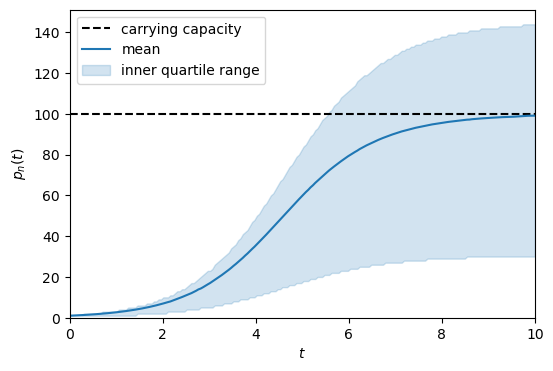

In [149]:
plt.figure(figsize=(6, 4))
# plt.pcolor(sol.ts, jnp.arange(len(sol.ys[0])), sol.ys.T)
# plt.contourf(sol.ts, jnp.arange(len(sol.ys[0])), sol.ys.T, cbar=None)
n = jnp.arange(sol.ys.shape[1])
mean_trajectory = (n * sol.ys).sum(1)
plt.axhline(κ, color="k", linestyle="--", label="carrying capacity")
plt.plot(sol.ts, mean_trajectory, label="mean")
plt.fill_between(sol.ts, *quantile_trajectories, alpha=0.2, color="C0", label="inner quartile range")
plt.xlabel("$t$")
plt.ylabel("$p_n(t)$")
plt.legend(loc="upper left")
plt.xlim(sol.ts[0], sol.ts[-1])
plt.ylim(0, None)
plt.show()

## Possible next steps

- Compare to the standard Yule process
- Compare to Monte Carlo simulations:
  - using the mean-field logistic modulation
  - using the empirical population size logistic modulation
- Characterize sensitivity to state-space truncation